veri seti :
2 Mayıs 2020'den 16 Haziran 2022'ye kadar günlük (simüle edilmiş) sipariş sayısına sahibiz. Ayrıca sıcaklık ve pazarlama harcamalarına ilişkin veriler topladık.

Modeli her Pazartesi sabahı çalıştırmamız ve önümüzdeki 2 hafta için tahminler almamız gerekiyor. Sıcaklık sütunundaki değerlerin gerçek değerler olduğunu, dolayısıyla yalnızca mevcut ve geçmiş günler için geçerli olduğunu unutmayın. Öte yandan, pazarlama harcaması önceden bilebileceğimiz bir özellik olduğundan tahmin anında kullanılabilir.

Üstelik sadece nokta tahminleriyle değil, aynı zamanda tahminlerin belirsizliğiyle de ilgileniyoruz.
Bu modeli üretime koymadan önce model performansını değerlendirmemiz gerekiyor, bu nedenle lütfen numune dışı beklenen performans hakkında bilgi verin.

Gelecekteki meslektaşlarınızın bu ödevi değerlendireceğini unutmayın, bu nedenle şu şekilde değerlendirin: İncelenmeye hazır, iyi yapılandırılmış, takip edilmesi kolay, temiz kodlu, uygulanabilir olduğunda yorumlar/anlatımlar içeren bir çalışma. İade edilen rapor, düşünce sürecinizi açıklamaya ve gerekçenizi anlamamıza yardımcı olmaya yetecek kadar tartışma içermelidir.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")

In [17]:
# csv dosyasını oku
df = pd.read_csv("data-train.csv")
df

,date,orders,temperature,media_spend
0,2020-05-02,54,18.270322,0.0
1,2020-05-03,63,19.882444,0.0
2,2020-05-04,56,16.878095,0.0
3,2020-05-05,65,21.878648,0.0
4,2020-05-06,64,21.112398,0.0
...,...,...,...,...
771,2022-06-12,76,11.472592,0.0
772,2022-06-13,78,NaN,0.0
773,2022-06-14,79,11.813969,0.0
774,2022-06-15,77,10.110713,0.0


In [18]:
# date sutununu datetime ve index haline dönüştür
df = pd.read_csv("data-train.csv",parse_dates=["date"],index_col="date").asfreq("D")
df.head(3)

,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0


In [19]:
# veriyi kontrol et
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 776 entries, 2020-05-02 to 2022-06-16
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       776 non-null    int64  
 1   temperature  756 non-null    float64
 2   media_spend  776 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.2 KB


In [20]:
# eksik veri kontrolü

df.isnull().sum()

orders          0
temperature    20
media_spend     0
dtype: int64

In [21]:
df["temperature"] = df["temperature"].interpolate()

In [22]:
df.isnull().sum()

orders         0
temperature    0
media_spend    0
dtype: int64

<Figure size 1000x800 with 0 Axes>

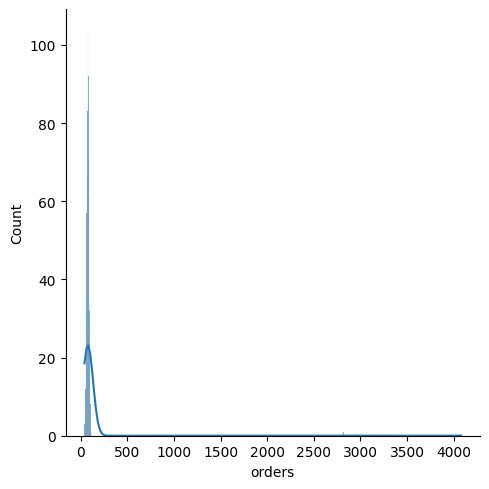

In [23]:
# hedef sutununu görselleştirip verilerin dağılımına bakıyorum. normal dağılımda olmasını istiyorum. 
plt.figure(figsize=(10,8))
sns.displot(df["orders"],kde=True)
plt.show()

# sonuç : dağılımı çok kötü, bunun için aykırı değerlerini kontrol edeceğim

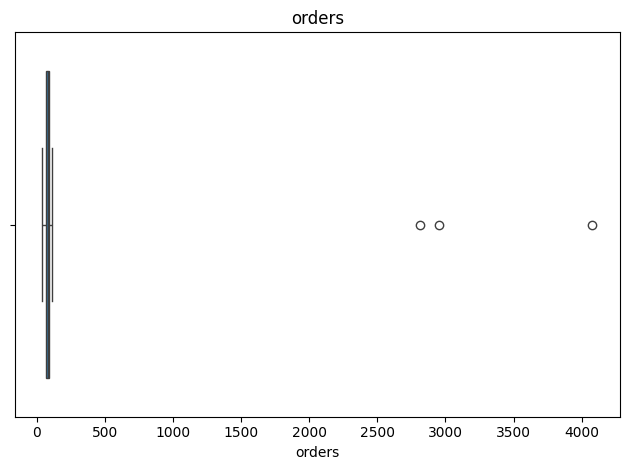

In [24]:
# Boxplot çizin
sns.boxplot(x=df["orders"])
plt.title("orders")
plt.tight_layout()
plt.show()

In [25]:
# aykırı değerleri min-max ile baskılıyorum

def aykiri_degerleri_min_max_sinirlar_ile_doldur(df, sutunlar):
    for col in sutunlar:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        alt_sinir = Q1 - 1.5 * IQR
        ust_sinir = Q3 + 1.5 * IQR

        df.loc[df[col] < alt_sinir, col] = alt_sinir
        df.loc[df[col] > ust_sinir, col] = None

    
        
    return df

# Aykırı değerleri düzeltmek istediğiniz sütunları seçin
secilen_sutunlar = ["orders"] 

# Aykırı değerleri düzelt
df = aykiri_degerleri_min_max_sinirlar_ile_doldur(df, secilen_sutunlar)

df["orders"] = df["orders"].interpolate()



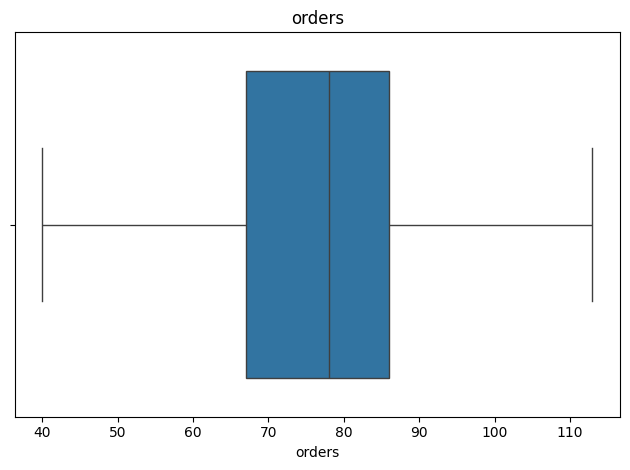

In [26]:
# tekrardan kontrol ediyorum
# Boxplot çizin

sns.boxplot(x=df["orders"])
plt.title("orders")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

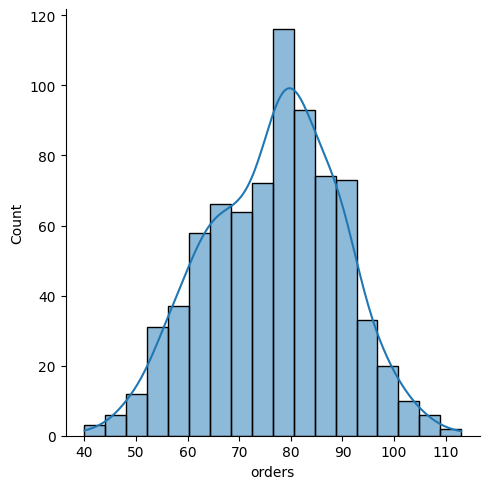

In [27]:
# aykırı değerleri baskıladıktan sonra tekrardan dağılımını kontrol ediyorum

plt.figure(figsize=(10,8))
sns.displot(df["orders"],kde=True)
plt.show()

# sonuç : dağılım bir öncekine göre daha düzenli görünüyor

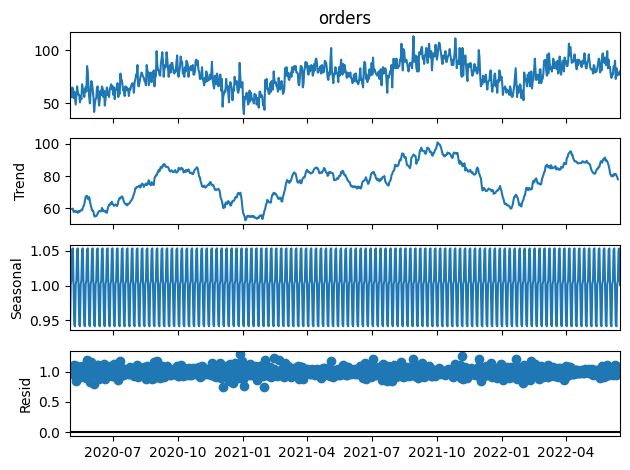

In [28]:
# verimiz günlük bir veri, o yüzden periyodu 7 olarak seçtim
# trend, mevsimsellik ve hata payını kontrol ediyorum

from statsmodels.tsa.seasonal import seasonal_decompose
dec_df = seasonal_decompose(df["orders"], model="mul", period=7)
dec_plot = dec_df.plot()

#Bu şekilde sonuçlara bakacak olursak, trend var,trend varsa durağan değildir,ayrıca mevsimsellikte vardır. bunları kontrol edelim

In [29]:
# durağan testi p_value 0.05 den büyükse durağan değildir

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df["orders"])
p_value = adf_test[1]
print(p_value)

# sonuç : durağan değil

0.10942486247172384


In [30]:
# durağan hale getirme

df1 = df.diff().dropna()

adf_test = adfuller(df1["orders"])
p_value = adf_test[1]
print(p_value)

# sonuç = bir kere diff işleminde durağan hale geldi

1.0537205601130818e-14


**<font color=red>acf ve pacf grafiğine bakıp modelleme hakkında bilgi edinelim**

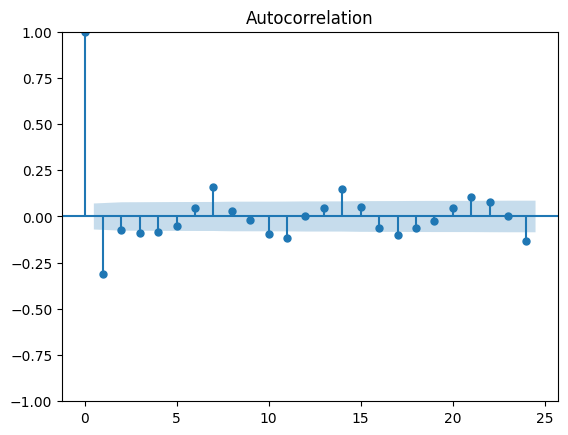

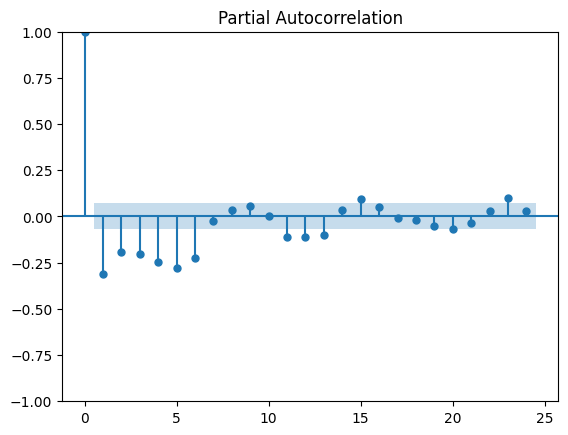

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df1["orders"], lags=24)

fig = plot_pacf(df1["orders"], lags=24)

# sonuç : grafiklere bakarak model hakkında sağlıklı bir hüküm veremedim

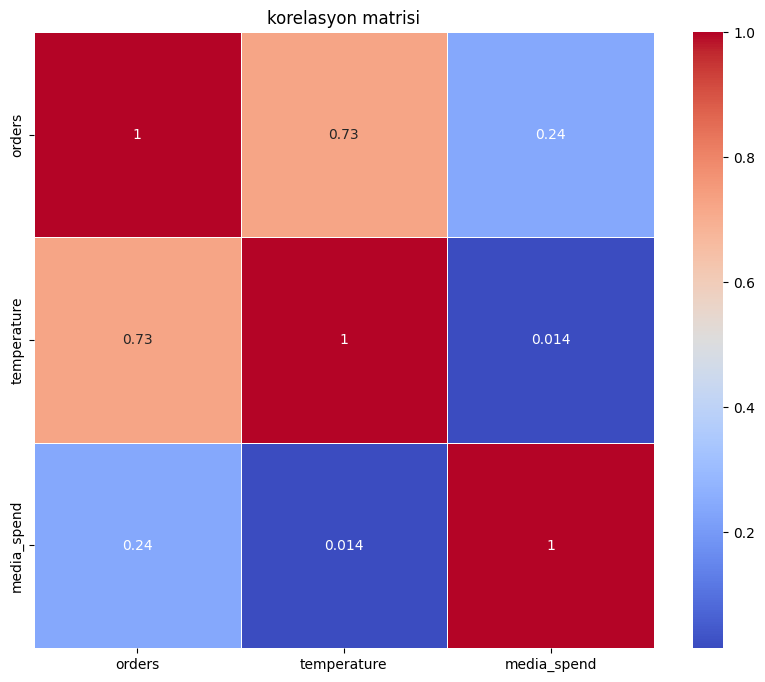

In [32]:
# hedef değişkenimiz ile diğer değişkenler arasındaki korelasyon matrisini inceliyoruz

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm",linewidths=.5)
plt.title("korelasyon matrisi")
plt.show()

# sonuç : media_spend ve temperature kolonlarının korelasyonları düşük olduğu için hedef sutunumuz üzerinde etkisi az olacaktır bunun için bu iki kolonu işlemlerimde kullanmayacağım

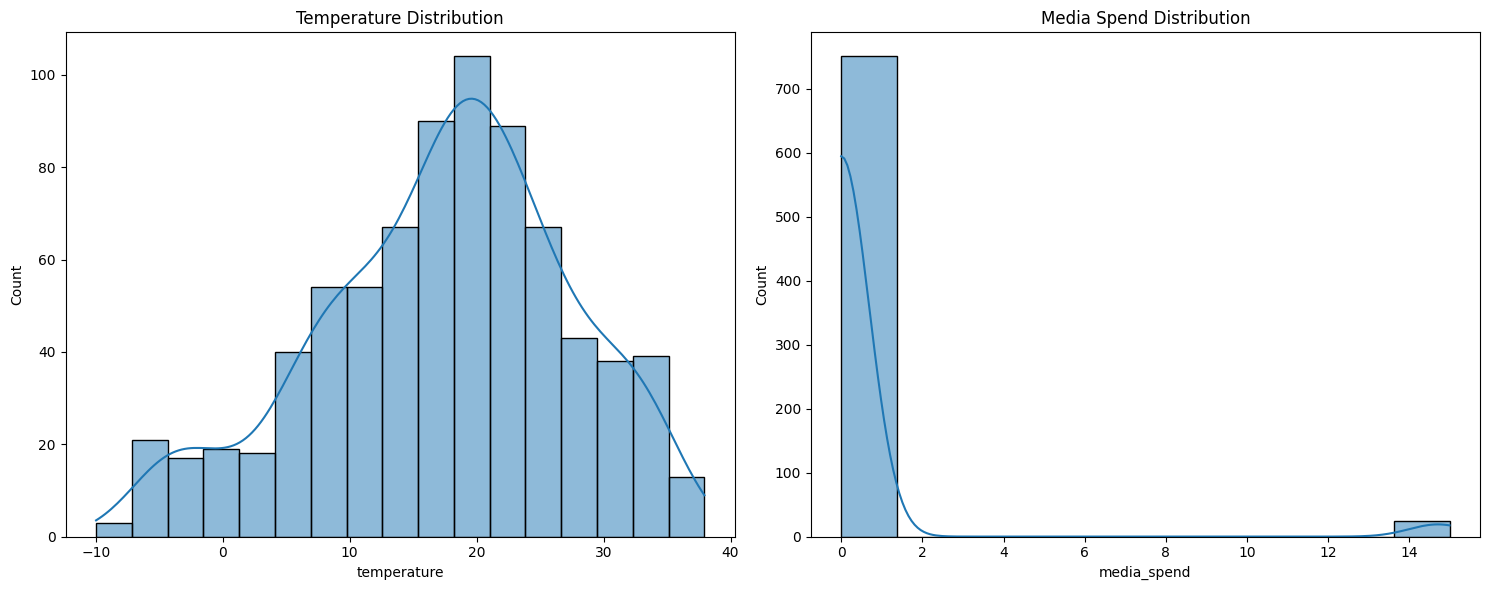

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2 sütunlu bir subplot oluşturma
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Her bir grafik için displot çağrısı
sns.histplot(df["temperature"], kde=True, ax=axes[0])
axes[0].set_title('Temperature Distribution')

sns.histplot(df["media_spend"], kde=True, ax=axes[1])
axes[1].set_title('Media Spend Distribution')

plt.tight_layout()  # Grafiklerin arasındaki boşluğu ayarlar
plt.show()


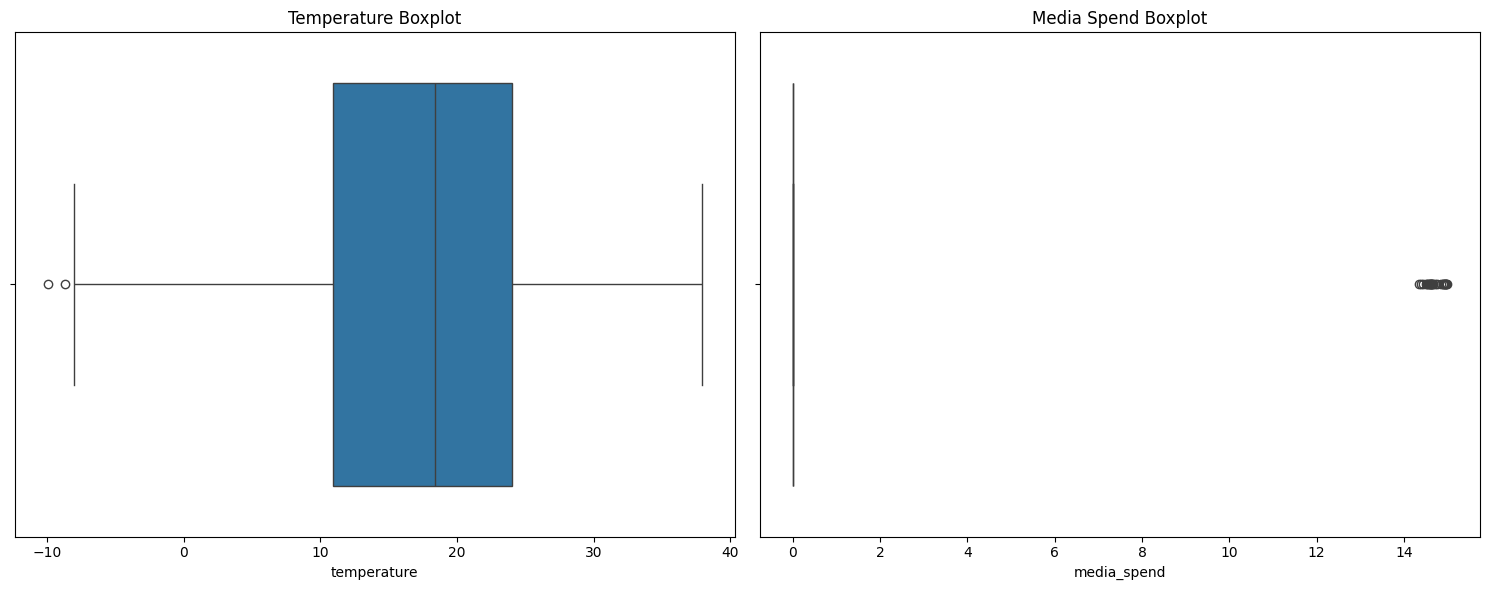

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2 sütunlu bir subplot oluşturma
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Her bir grafik için boxplot çağrısı
sns.boxplot(x=df["temperature"], ax=axes[0])
axes[0].set_title('Temperature Boxplot')

sns.boxplot(x=df["media_spend"], ax=axes[1])
axes[1].set_title('Media Spend Boxplot')

plt.tight_layout()  # Grafiklerin arasındaki boşluğu ayarlar
plt.show()


In [35]:
df.head()

,orders,temperature,media_spend
date,,,
2020-05-02,54.0,18.270322,0.0
2020-05-03,63.0,19.882444,0.0
2020-05-04,56.0,16.878095,0.0
2020-05-05,65.0,21.878648,0.0
2020-05-06,64.0,21.112398,0.0


In [36]:
# durağan testi p_value 0.05 den büyükse durağan değildir

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df["temperature"])
p_value = adf_test[1]
print(p_value)

# sonuç : durağan değil

0.13178731632527096


In [37]:
# Exog değişkeni için de aynı dönüşümü uygulama
df["temperature"] = df["temperature"].diff().dropna() 

# İlk değerler NaN olacağı için onları düşürme
df.dropna(inplace=True)

adf_test = adfuller(df["temperature"])
p_value = adf_test[1]
print(p_value)

0.0


In [38]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df["media_spend"])
p_value = adf_test[1]
print(p_value)

0.0


In [39]:
train, test = df[:-14], df[-14:]

In [40]:
# hiperparametre bul

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
for p in range(0, 2):
    for q in range(0, 2):
        for P in range(0, 2):
            for Q in range(0, 2):
                for d in range(0,2):
                    for D in range(0,2):
                        for trend in ["t", "n", "c", "ct"]:
                            model = SARIMAX(train["orders"], order=(p, d, q), seasonal_order=(P, D, Q, 7),trend=trend,exog=train[["temperature","media_spend"]])
                            model_fit = model.fit()
                            aic = model_fit.aic
                            bic = model_fit.bic
                            order_aic_bic.append((p, d, q, P, D, Q, trend, aic, bic))
                
order_df = pd.DataFrame(order_aic_bic, columns=["p", "d", "q", "P", "D", "Q", trend, "AIC", "BIC"])
print(order_df.sort_values("AIC").head(3))
print(order_df.sort_values("BIC").head(3))

     p  d  q  P  D  Q ct          AIC          BIC
221  1  1  1  0  1  1  n  4500.716437  4528.460829
253  1  1  1  1  1  1  n  4502.609629  4534.978086
222  1  1  1  0  1  1  c  4502.636558  4535.005014
     p  d  q  P  D  Q ct          AIC          BIC
221  1  1  1  0  1  1  n  4500.716437  4528.460829
253  1  1  1  1  1  1  n  4502.609629  4534.978086
222  1  1  1  0  1  1  c  4502.636558  4535.005014


In [41]:
# Modeli oluştur
from sklearn.linear_model import Ridge
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train["orders"], order=(1,1,1), seasonal_order=(0,1,1,7),trend="n",exog=train[["temperature","media_spend"]])
        
# Modeli eğit              
model_fit = model.fit()

# Tahminleri yap
fitted = model_fit.predict()

# hata payını al
resids = model_fit.resid

# tahminleri train içine ekleyin
train.loc[:,"fitted"] = fitted

In [42]:
# P değerini kontrol et 0.05 den küçük olması performans açısından daha iyi sonuç verir

print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            orders   No. Observations:                  761
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2244.358
Date:                           Fri, 15 Mar 2024   AIC                           4500.716
Time:                                   16:20:52   BIC                           4528.461
Sample:                               05-03-2020   HQIC                          4511.405
                                    - 06-02-2022                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.5268      0.028     18.862      0.000       0.472       0.582
media_spend     0.9584      0.049     19

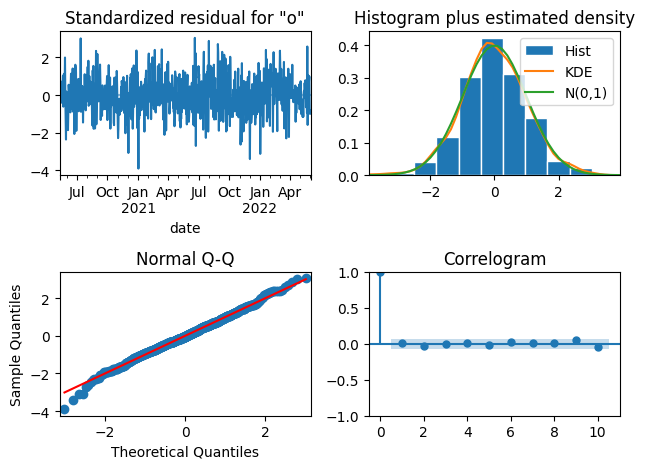

In [43]:
diags = model_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

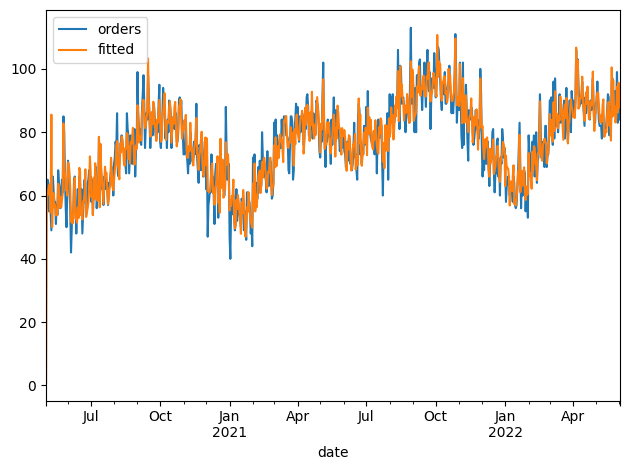

In [44]:
# train setinde ki orders ile tahminlerimin aynı hareketi yapmasını istiyorum
train[["orders","fitted"]].plot()
plt.tight_layout()
plt.show()

**<font color=red>test verisi için**

In [45]:
# test verilerinin tahminini yap

test_predicted = model_fit.forecast(steps=len(test),exog=test[["temperature","media_spend"]], index=test.index)

<Figure size 800x600 with 0 Axes>

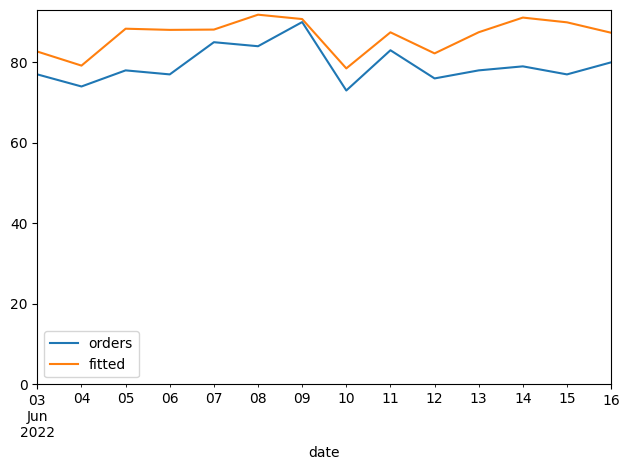

In [46]:
# test setinde ki orders ile tahminlerimin aynı hareketi yapmasını istiyorum

test.loc[:,"fitted"] = test_predicted

plt.figure(figsize=(8, 6))
test[["orders","fitted"]].plot()
plt.ylim(0, 93)
plt.tight_layout()
plt.show()


**<font color=red>train ile test verilerini karşılaştır ve overfit kontrolü yap**

In [47]:
# train verisi için; 
print("---train verisi---")
mae = np.mean(np.abs(resids.values))
mse = np.mean(np.square(resids.values))
rmse = np.sqrt(np.mean(np.square(resids.values)))
print("MAE :",mae)
print("MSE :",mse)
print("RMSE :",rmse)

print()

# test verisi için;
print("---test verisi---")
mae = np.mean(np.abs(test["orders"]-test_predicted))
mse = np.mean(np.square(test["orders"]-test_predicted))
rmse = np.sqrt(np.mean(np.square(test["orders"]-test_predicted)))
print("MAE :",mae)
print("MSE :",mse)
print("RMSE :",rmse)

---train verisi---
MAE : 3.857238520679257
MSE : 29.403755347035872
RMSE : 5.4225229687882255

---test verisi---
MAE : 7.288148355820824
MSE : 64.78078209171953
RMSE : 8.048650948557748


**<font color=red>değerlendirme**

**<font color=red>geleceğe yönelik tahmin**

In [48]:
unseen_data = pd.read_csv("data-unseen-features.csv")
unseen_data.head(3)

,date,temperature,media_spend
0,2022-06-17,11.923126,0.0
1,2022-06-18,14.986238,0.0
2,2022-06-19,11.003947,0.0


In [49]:
unseen_data.shape

(14, 3)

In [50]:
df_data = pd.read_csv("data-train.csv")
df_data.head(3)

,date,orders,temperature,media_spend
0,2020-05-02,54,18.270322,0.0
1,2020-05-03,63,19.882444,0.0
2,2020-05-04,56,16.878095,0.0


In [51]:
df_data.shape

(776, 4)

In [52]:
df_data = df_data.drop(columns="orders")
df_data.head(3)

,date,temperature,media_spend
0,2020-05-02,18.270322,0.0
1,2020-05-03,19.882444,0.0
2,2020-05-04,16.878095,0.0


In [53]:
df_data.shape

(776, 3)

In [54]:
df_unseen = pd.concat([df_data,unseen_data],axis=0)
df_unseen.head(3)

,date,temperature,media_spend
0,2020-05-02,18.270322,0.0
1,2020-05-03,19.882444,0.0
2,2020-05-04,16.878095,0.0


In [55]:
df_unseen.shape

(790, 3)

In [56]:
df_unseen

,date,temperature,media_spend
0,2020-05-02,18.270322,0.0
1,2020-05-03,19.882444,0.0
2,2020-05-04,16.878095,0.0
3,2020-05-05,21.878648,0.0
4,2020-05-06,21.112398,0.0
...,...,...,...
9,2022-06-26,12.669216,0.0
10,2022-06-27,9.819516,0.0
11,2022-06-28,18.834372,0.0
12,2022-06-29,NaN,0.0


In [57]:
df_unseen.isnull().sum()

date            0
temperature    21
media_spend     0
dtype: int64

In [58]:
df_unseen["temperature"] = df_unseen["temperature"].interpolate()

In [59]:
df_unseen.isnull().sum()

date           0
temperature    0
media_spend    0
dtype: int64

In [60]:
# date sutununu datetime ve index haline dönüştür
df_unseen['date'] = pd.to_datetime(df_unseen['date'])
df_unseen.set_index('date', inplace=True)

In [61]:
df_unseen.head(3)

,temperature,media_spend
date,,
2020-05-02,18.270322,0.0
2020-05-03,19.882444,0.0
2020-05-04,16.878095,0.0


In [62]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_unseen["temperature"])
p_value = adf_test[1]
print(p_value)

0.11821973696280497


In [63]:
df_unseen["temperature"] = df_unseen["temperature"].diff().dropna()

In [64]:
# İlk değerler NaN olacağı için onları düşürme
df_unseen.dropna(inplace=True)

adf_test = adfuller(df_unseen["temperature"])
p_value = adf_test[1]
print(p_value)

0.0


In [65]:
df_unseen

,temperature,media_spend
date,,
2020-05-03,1.612122,0.0
2020-05-04,-3.004349,0.0
2020-05-05,5.000553,0.0
2020-05-06,-0.766250,0.0
2020-05-07,-2.067746,0.0
...,...,...
2022-06-26,3.384897,0.0
2022-06-27,-2.849700,0.0
2022-06-28,9.014856,0.0


In [66]:
unsenn = df_unseen.iloc[-14:]
unsenn

,temperature,media_spend
date,,
2022-06-17,0.930988,0.000000
2022-06-18,3.063113,0.000000
2022-06-19,-3.982292,0.000000
2022-06-20,1.695313,0.000000
2022-06-21,5.153040,0.000000
2022-06-22,-6.251000,0.000000
2022-06-23,4.606699,14.847883
2022-06-24,-3.255931,0.000000
2022-06-25,-3.667748,14.664207


In [67]:
# verimizin tamamıyla tekrardan fit ediyorum
model = SARIMAX(df["orders"], order=(1,1,1), seasonal_order=(0,1,1,7),trend="n",exog=df[["temperature","media_spend"]])

In [68]:
# Önce modelinizi eğitin
model_fit = model.fit()

# Exogenous değişkenlerin değerlerini alın ve numpy dizisine dönüştürün
exog_values = unsenn[["temperature", "media_spend"]].values

# Modeli kullanarak tahmin yapın
tahmin_değerleri = model_fit.forecast(steps=len(unsenn), exog=exog_values)

# Tahmin sonuçlarını yazdırın
print(tahmin_değerleri)


2022-06-17    75.664487
2022-06-18    75.939858
2022-06-19    76.251360
2022-06-20    79.853611
2022-06-21    85.358992
2022-06-22    79.096216
2022-06-23    95.334135
2022-06-24    73.367663
2022-06-25    86.491469
2022-06-26    80.233160
2022-06-27    77.569835
2022-06-28    87.503896
2022-06-29    80.695480
2022-06-30    77.011662
Freq: D, Name: predicted_mean, dtype: float64


In [69]:
# df_unseen DataFrame'i oluşturma
df_unseen = pd.DataFrame(data=tahmin_değerleri)

# 'ORDERS' sütun adını değiştirme
df_unseen = df_unseen.rename(columns={"predicted_mean": "orders"})


# 'date' adında bir sütun olarak index'i kullanma
df_unseen['date'] = df_unseen.index

# kolonların yerini değiştir
df_unseen = df_unseen[["date","orders"]]

# Index sütununu sıfırdan başlatma
df_unseen.reset_index(drop=True, inplace=True)


# Veri çerçevesini yazdırma
df_unseen.head(14)




,date,orders
0,2022-06-17,75.664487
1,2022-06-18,75.939858
2,2022-06-19,76.251360
3,2022-06-20,79.853611
4,2022-06-21,85.358992
5,2022-06-22,79.096216
6,2022-06-23,95.334135
7,2022-06-24,73.367663
8,2022-06-25,86.491469
9,2022-06-26,80.233160


In [70]:
df_unseen.to_csv('sample_submission.csv', index=False)